# Tracking Covid19 statistics in South Africa

## Data source

Using Covid19 data from John Hopkins University:  
https://github.com/CSSEGISandData/COVID-19  
https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6  
https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series  

World population data taken from  
https://data.worldbank.org/indicator/sp.pop.totl

Other data source (not used here):  
https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide


## Other Trackers

Much nicer than this one...

South Africa  
https://datastudio.google.com/reporting/15817068-62f2-4101-8e0f-385e2ddd9326/page/wI9JB  
http://cip.csag.uct.ac.za/monitoring/corona/

International  
https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6  
https://www.covidvisualizer.com/  
https://www.worldometers.info/coronavirus/  

Some ideas of what to track:   

https://twitter.com/jburnmurdoch  
https://twitter.com/jburnmurdoch/status/1242904596856614912  
https://robjhyndman.com/hyndsight/logratios-covid19/  
https://joachim-gassen.github.io/2020/03/tidying-the-john-hopkins-covid-19-data/  

https://github.com/twiecki/covid19  
https://twitter.com/twiecki  
https://twitter.com/twiecki/status/1246056084982415360  
https://www.quantopian.com/posts/covid-19-growth-analysis (old post, perhaps useful links)  
https://covid19dashboards.com/growth-analysis/  
https://github.com/github/covid19-dashboard  

## Analysis

The results are at the end of the notebook

In [1]:
import pandas as pd
import numpy as np
import urllib.request as request
import matplotlib.pyplot as plt
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
import matplotlib.dates as mdates
from datetime import datetime


Read the data as currently stored on GitHub in the JHU repository

In [2]:
ghFolder = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series'
ghFiles = {
    'Confirmed':['time_series_covid19_confirmed_global.csv','red',r'$\leftarrow$','-' ],
    'Deaths':['time_series_covid19_deaths_global.csv','blue',r'$\rightarrow$',':' ],
    'Recovered':['time_series_covid19_recovered_global.csv','green',r'$\leftarrow$','--' ],
}

In [3]:
dfg={}
for i,key  in enumerate(ghFiles.keys()):
    # read data from github
    print(key)
    dfg[key] = pd.read_csv('/'.join([ghFolder,ghFiles[key][0]]))



Confirmed
Deaths
Recovered


Get the world statistics

In [4]:
dfw = {}
for i,key in enumerate(dfg.keys()):
    df = dfg[key]
    dfsum = df.sum(axis = 0, skipna = True) 
    dfsum = dfsum.drop(['Country/Region','Lat','Long']).to_frame()
    dfsum.columns = ['Count']
    # find all dates with zero incidence
    indexNames = dfsum[dfsum['Count'] == 0].index
     # Delete these row indexes from dataFrame
    dfsum = dfsum.drop(indexNames)

    # get dates from string
    dfsum.reset_index(level=0, inplace=True)
    dfsum['Date'] = pd.to_datetime(dfsum['index'] ,dayfirst=True, format='%m/%d/%y')
     # Delete these row index column from dataFrame
    dfsum = dfsum.drop('index',axis=1)
    dfw[key] = dfsum

# print(dfw)

Get South Africa statistics

In [5]:
dfs = {}
for i,key in enumerate(dfg.keys()):
    df = dfg[key]
    dfT = df[df['Country/Region']=='South Africa'].T
    dfT = dfT.drop(['Province/State', 'Country/Region','Lat','Long'])
    dfT.columns=['Count']
    
    # find all dates with zero incidence
    indexNames = dfT[dfT['Count'] == 0].index
     # Delete these row indexes from dataFrame
    dfT = dfT.drop(indexNames)

    # get dates from string
    dfT.reset_index(level=0, inplace=True)
    dfT['Date'] = pd.to_datetime(dfT['index'] ,dayfirst=True, format='%m/%d/%y')
    
    dfs[key] = dfT

# print(dfs)

## Plot ZA data

The graphs below show the South African statistics along rows as (1) cases confirmed, (2) deaths, and (3) recovered.  The columns show (1) linear y-scale [shows magnitude better], (2) logarithmic y-scale [for comparison with most other graphs], and (3) the daily changes.


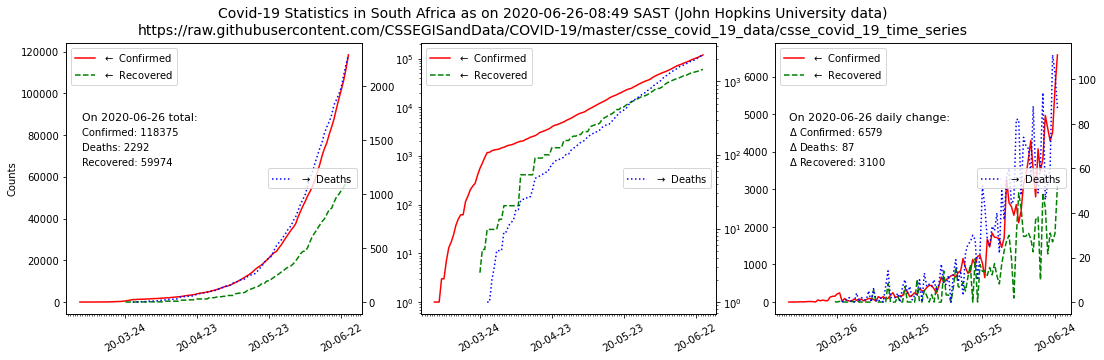

In [10]:
strnow = f"{datetime.today().strftime('%Y-%m-%d-%H:%M')} SAST (John Hopkins University data)"
ptitle = f'Covid-19 Statistics in South Africa as on {strnow}\n{ghFolder}'
ptypes = ['Total cases (linear Y)','Total cases (logarithmic Y)','Daily new cases (linear Y)']

fig, axs = plt.subplots(1,3,figsize=(18,5))
fig.suptitle(ptitle, fontsize=14)
axt = [a.twinx() for a in axs]

peopleWorld = 7.53e9
peopleZA = 56.72e6
dicCnts = {}
dicDifs = {}

for i,key in enumerate(dfs.keys()):

    dfS = dfs[key]
    dfW = dfw[key]
    dfS = dfS.join(dfW.set_index('Date'), on='Date',rsuffix='_W')
    
    # plot the data
    color = ghFiles[key][1]
    linestyle = ghFiles[key][3]
    label = f'{ghFiles[key][2]} {key}'
        
    ax = axt if 'Death' in key else axs
        
    ax[0].plot(dfS['Date'],dfS['Count'], label=label,linestyle=linestyle,color=color)
    ax[1].semilogy(dfS['Date'],dfS['Count'],label=label,linestyle=linestyle,color=color)
    ax[2].plot(dfS['Date'][1:],np.diff(dfS['Count']),label=label,linestyle=linestyle,color=color)  

    if i==0:
        tlocx = dfS['Date'].values[1]

    dicCnts[key] = dfS['Count'].values[-1]
    dicDifs[key] = np.diff(dfS['Count'])[-1]

# print on current day
tlocyCnts = 0.7 * ax[0].get_ylim()[1] 
tlocyDifs = 0.7 * ax[2].get_ylim()[1] 
ax[0].text(tlocx, tlocyCnts, f'On {datetime.today().strftime("%Y-%m-%d")} total:', fontsize=11)
ax[2].text(tlocx, tlocyDifs, f'On {datetime.today().strftime("%Y-%m-%d")} daily change:', fontsize=11)
for ik,key in enumerate(dicCnts.keys()):
    ax[0].text(tlocx, tlocyCnts-(ik+1)*tlocyCnts/12, f'{key}: {dicCnts[key]}', fontsize=10)
    ax[2].text(tlocx, tlocyDifs-(ik+1)*tlocyDifs/12, f'$\Delta$ {key}: {dicDifs[key]}', fontsize=10)

for i in [0,1,2]:
    if i==0:
        axs[0].set_ylabel('Counts')
    
    axs[i].legend()
    axt[i].legend(loc='center right')

    axs[i].xaxis.set_tick_params(rotation=30, labelsize=10)
    # format the ticks
    axs[i].xaxis.set_major_locator(mdates.DayLocator(interval=30))
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))
    axs[i].xaxis.set_minor_locator(mdates.DayLocator())



## Accounting for Day-0

Using the World Bank world population data for 2018 (close enough for our purpose).


In [7]:

# read the world population
df = pd.read_csv('data/API_SP-POP-TOTL_DS2_en_csv_v2_887275.csv')
# only a few columns, i.e., 2018 data
dfWpop = df[df.columns[df.columns.isin(['Country Name', '2018'])]]
dfWpop.columns = ['Country/Region','Population']
dfWpop = dfWpop.set_index('Country/Region')

#  covid data - confirmed
dfCnf = pd.read_csv('/'.join([ghFolder,ghFiles['Confirmed'][0]]))
dfCnf = dfCnf.drop(['Province/State','Lat','Long'], axis=1)
# group multiple entries per country together
dfCnf = dfCnf.groupby(by=dfCnf['Country/Region'], axis=0).sum()

#  covid data - deaths
dfDth = pd.read_csv('/'.join([ghFolder,ghFiles['Deaths'][0]]))
dfDth = dfDth.drop(['Province/State','Lat','Long'], axis=1)
# group multiple entries per country together
dfDth = dfDth.groupby(by=dfDth['Country/Region'], axis=0).sum()


# convert the date columns to Python datetime
def convdate(column):
    try:
        return pd.to_datetime(column,dayfirst=True, format='%m/%d/%y')
    except Exception:
        return column
columns = [convdate(column) for column in dfCnf.columns]
dfCnf.columns = columns
columns = [convdate(column) for column in dfDth.columns]
dfDth.columns = columns

#  normalise each country to D0 by removing rows with zero count

dfCnfDo = pd.DataFrame() # actual counts
dfCnfDon = pd.DataFrame() # normalised to population
# transpose to get counties in columns
dfCnfT = dfCnf.T

dfDthDo = pd.DataFrame() # actual counts
dfDthDon = pd.DataFrame() # normalised to population
# transpose to get counties in columns
dfDthT = dfDth.T


# print(list(dfCnfT.columns))

WorldPop = 0
for column in dfCnfT.columns:
    if column in dfWpop.index and not np.isnan(dfWpop.loc[column]['Population']):

        df = dfCnfT[column] 
        # starting new index as int from zero, then drop index column
        df = df[df != 0].reset_index()
        df = df.drop(['index'],axis=1)
        # make from Series to DataFrame and concat to master
        df = pd.DataFrame(df)
        dfCnfDo = pd.concat([dfCnfDo, df], axis=1)
        dfCnfDon = pd.concat([dfCnfDon, df/dfWpop.loc[column]['Population']], axis=1)
        WorldPop += dfWpop.loc[column]['Population']
        
        df = dfDthT[column] 
        # starting new index as int from zero, then drop index column
        df = df[df != 0].reset_index()
        df = df.drop(['index'],axis=1)
        # make from Series to DataFrame and concat to master
        df = pd.DataFrame(df)
        dfDthDo = pd.concat([dfDthDo, df], axis=1)
        dfDthDon = pd.concat([dfDthDon, df/dfWpop.loc[column]['Population']], axis=1)
#         WorldPop += dfWpop.loc[column]['Population']
        

# now we have df of normalised confirmed for countries starting from day zero


The comparison of South Africa with other countries and the rest of the world is a gross simplification using the current snapshot. It is calculated as the cases in each country divided by the population. It was pointed out that this simple ratio is not a good indicator because in smaller countries the population is small, giving a high ratio (see here:
https://twitter.com/jburnmurdoch/status/1242904596856614912).

Furthermore, dividing by the population is simply moving the curve up or down the log scale, not changing anything else (just shifting).  The upward shift is larger in smaller countries, argument given in the previous paragraph.

The graphs show some countries in dotted lines and some in solid lines.  The dotted lines are countries not providing BCG vaccination and the solid lines are countries with a history of BCG vaccination.  There are some indications that countries with BCG vaccination do better in terms of infections and particularly death rates.



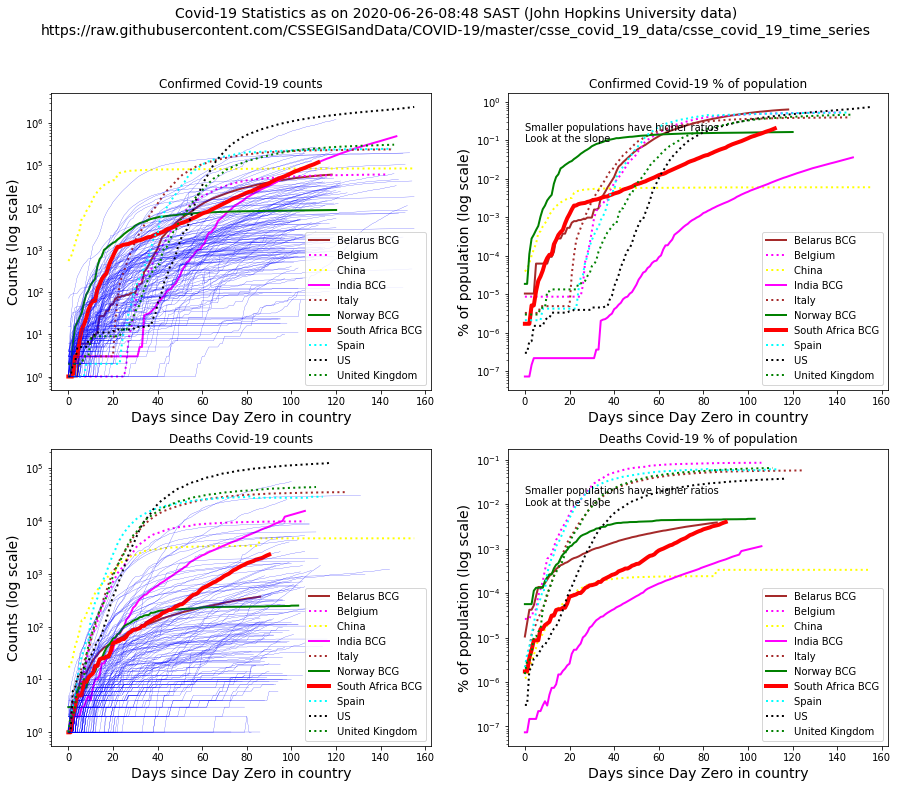

In [8]:

strnow = f"{datetime.today().strftime('%Y-%m-%d-%H:%M')} SAST (John Hopkins University data)"
ptitle = f'Covid-19 Statistics as on {strnow}\n{ghFolder}'
fig, axs = plt.subplots(2,2,figsize=(15,12))

# print(list(dfCnfDo.columns))

pcols = {
         'United Kingdom':['green',':',''],
         'Italy':['brown',':',''],
         'US':['black',':',''],
         'Spain':['cyan',':',''],
         'Belgium':['magenta',':',''],
         'China':['yellow',':',''],
         'South Africa':['red','-','BCG'],
         'India':['magenta','-','BCG'],
         'Belarus':['brown','-','BCG'],
         'Norway':['green','-','BCG'],
}

for i,scen in enumerate(zip(['Confirmed','Deaths'],[dfCnfDo,dfDthDo],[dfCnfDon,dfDthDon])):
    for column in dfCnfDo.columns:
        color ='blue'
        linewidth=0.2

        if column not in pcols.keys():
            axs[i,0].semilogy(scen[1].index,scen[1][column],color=color,linewidth=linewidth)

        if column in pcols.keys():
            linewidth = 4 if 'South Africa' in column else 2
            axs[i,0].semilogy(scen[1].index,scen[1][column],color=pcols[column][0],linewidth=linewidth,
                              label=f'{column} {pcols[column][2]}',linestyle=pcols[column][1])
            axs[i,1].semilogy(scen[2].index,100*scen[2][column],color=pcols[column][0],linewidth=linewidth,
                              label=f'{column} {pcols[column][2]}',linestyle=pcols[column][1])

#     axs[i,1].plot(scen[2].index,100*scen[1].sum(axis=1)/WorldPop,color='blue',linewidth=2,label='World',linestyle='--')

    axs[i,0].set_title(f'{scen[0]} Covid-19 counts')
    axs[i,0].set_xlabel('Days since Day Zero in country', fontsize=14)
    axs[i,0].set_ylabel('Counts (log scale)', fontsize=14);

    axs[i,1].set_title(f'{scen[0]} Covid-19 % of population')
    axs[i,1].set_xlabel('Days since Day Zero in country', fontsize=14)
    axs[i,1].set_ylabel('% of population (log scale)', fontsize=14);

    axs[i,0].legend();
    axs[i,1].legend();

axs[0,1].text(0, .1, 'Smaller populations have higher ratios\nLook at the slope', ha='left', wrap=True)
axs[1,1].text(0, .01, 'Smaller populations have higher ratios\nLook at the slope', ha='left', wrap=True)

fig.suptitle(ptitle, fontsize=14);


In [9]:
# to get software versions
# https://github.com/rasbt/watermark
# An IPython magic extension for printing date and time stamps, version numbers, and hardware information. 
# you only need to do this once
# !pip install watermark

%load_ext watermark
%watermark -v -m -p numpy,pandas -g 

CPython 3.7.3
IPython 7.14.0

numpy 1.18.4
pandas 1.0.3

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
Git hash   : 689020596b2938bbf5b9a3973794b8cce0335f4b
